In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.appName("PySparksi618f21").config("spark.some.config.option", "some-value").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df1 = spark.read.options(header=True).csv("Income/kaggle_income.csv")
df2 = spark.read.options(header=True).csv("Edu/states.csv")

In [4]:
df1.createOrReplaceTempView("income")
df2.createOrReplaceTempView("edu")

In [5]:
q1 = sqlContext.sql("select State_name as state, mean(Median) as meanMedian from income group by state order by state")
q1.createOrReplaceTempView("incomeByState")

In [6]:
q2 = sqlContext.sql("select * from edu where year = 2016 order by state")
q2.createOrReplaceTempView("eduByState2016")

In [7]:
q3 = sqlContext.sql("select * from incomeByState as a inner join eduByState2016 as b on a.state = b.STATE")
q3.createOrReplaceTempView("Problem1")
q3.toPandas().to_csv('Problem1.csv', header=True, index=None)

In [8]:
q4 = sqlContext.sql("select STATE as state, mean(cleanExpenditure) as meanCleanExpenditure from (select STATE, YEAR, TOTAL_EXPENDITURE as cleanExpenditure from edu) group by state order by state")
q4.createOrReplaceTempView("meanExpenditureByState")

In [9]:
q5 = sqlContext.sql("select * from incomeByState as a inner join meanExpenditureByState as b on a.state = b.state order by b.meanCleanExpenditure")
q5.createOrReplaceTempView("Problem2_01")
q5.toPandas().to_csv('Problem2_01.csv', header=True, index=None)

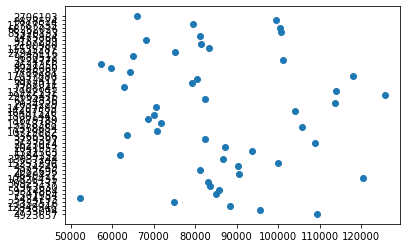

In [10]:
dfq3 = q3.toPandas()
plt.scatter(dfq3['meanMedian'], dfq3['TOTAL_EXPENDITURE'])

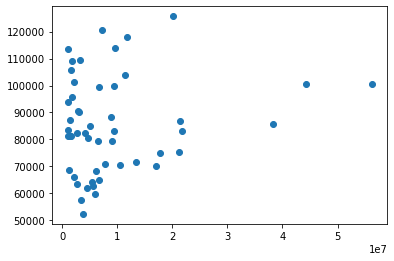

In [11]:
dfq5 = q5.toPandas()
plt.scatter(dfq5['meanCleanExpenditure'], dfq5['meanMedian'])

In [12]:
# increase rate of meanCleanExpenditure
q6 = sqlContext.sql("select * from (select STATE, mean(expenditureIncreaseRate) as meanExpenditureIncreaseRate from (select STATE, (postExpenditure-preExpenditure)/preExpenditure as expenditureIncreaseRate, preYear, postYear from (select a.STATE, a.YEAR as preYear, b.YEAR as postYear, a.TOTAL_EXPENDITURE as preExpenditure, b.TOTAL_EXPENDITURE as postExpenditure from (select * from edu where YEAR < 2016) as a inner join (select * from edu where YEAR > 1992) as b where a.YEAR = b.YEAR-1 and a.STATE = b.STATE)) group by STATE order by STATE) as a inner join incomeByState as b on a.STATE = b.state")
q6.createOrReplaceTempView("Problem2_02")
q6.toPandas().to_csv('Problem2_02.csv', header=True, index=None)

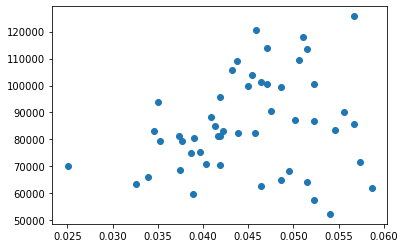

In [13]:
dfq6 = q6.toPandas()
plt.scatter(dfq6['meanExpenditureIncreaseRate'], dfq6['meanMedian'])

In [14]:
# MR to reduce edu/district.csv to county and city level
# do similar job as above
df3 = spark.read.options(header=True).csv("Edu/districts.csv")
df3.createOrReplaceTempView("edu_districts")

In [15]:
# County names may be the same among different states
state = "'Oklahoma'"
year = "'2016'"
query7 = "select County as county, mean(Median) as meanMedian from income where State_name = " +  state + " group by county order by county"
#query8 = "select * from edu_districts where YRDATA = " + year + " and STATE = " + state
query8 = "select * from edu_districts where STATE = " + state
q7 = sqlContext.sql(query7)
q8 = sqlContext.sql(query8)

In [16]:
def cat_q7(data):
    cat_list = []
    key = data['county']
    val = float(data['meanMedian'])
    cat_list.append((key, val))
    return cat_list

def cat_q8(data):
    cat_list = []
    key = (data['NAME'], int(data['YRDATA']))
    val = float(data['TOTALEXP'])
    cat_list.append((key, val))
    return cat_list

def join_county(data):
    join_list = []
    c = data[0][0]
    sd = data[1][0][0]
    year = data[1][0][1]
    meanMedian = data[0][1]
    totalExpenditure = data[1][1]
    temp = c.split()
    if 'County' in c or 'Borough' in c or 'Municipio' in c or 'Parish' in c or 'Municipality' in c:
        name_string = ' '.join(temp[:-1])
        if name_string.upper() in sd:
            join_list.append(((c, sd, year), (meanMedian, totalExpenditure)))
    elif 'Census Area' in c:
        name_string = ' '.join(temp[:-2])
        if name_string.upper() in sd:
            join_list.append(((c, sd, year), (meanMedian, totalExpenditure)))
    elif 'Columbia' in c:
        name_string = 'Columbia'
        if name_string.upper() in sd:
            join_list.append(((c, sd, year), (meanMedian, totalExpenditure)))
    elif 'District' not in c:
        name_string = c
        if name_string.upper() in sd:
            join_list.append(((c, sd, year), (meanMedian, totalExpenditure)))
    else:
        return join_list
    return join_list

In [17]:
q7_rdd = q7.rdd
q8_rdd = q8.rdd
cat_1 = q7_rdd.flatMap(cat_q7)
cat_2 = q8_rdd.flatMap(cat_q8).reduceByKey(lambda x, y: x+y)

In [18]:
joined_rdd = cat_1.cartesian(cat_2).flatMap(join_county).map(lambda x: (x[0][0], x[0][1], x[0][2], x[1][0], x[1][1]))
columnNames = ["county", "schoolDistrict", "year", "meanMedian", "totalExpenditure"]
df_joined_county = joined_rdd.toDF(columnNames)
df_joined_county.createOrReplaceTempView("joinedCountyOK")

In [19]:
df_joined_county.toPandas()

,county,schoolDistrict,year,meanMedian,totalExpenditure
0,Adair County,ADAIR SCH DIST 2,2013,63308.972772,7190.0
1,Adair County,ADAIR SCH DIST 2,2005,63308.972772,5591.0
2,Adair County,ADAIR SCH DIST 2,1997,63308.972772,3967.0
3,Adair County,ADAIR SCH DIST 2,2010,63308.972772,6985.0
4,Adair County,ADAIR SCH DIST 2,2002,63308.972772,4935.0
...,...,...,...,...,...
830,Tulsa County,TULSA CO AREA VOC-TECH SCH DIST 18,2010,34950.000000,80924.0
831,Tulsa County,TULSA SCH DIST 1,2005,34950.000000,342306.0
832,Tulsa County,TULSA CO AREA VOC-TECH SCH DIST 18,2002,34950.000000,59358.0
833,Tulsa County,TULSA SCH DIST 1,1997,34950.000000,225473.0


In [20]:
# make conclusion and judgement accordingly
q9 = sqlContext.sql("select * from joinedCountyOK where year = 2016")
q9.createOrReplaceTempView("Problem3_01")
q9.toPandas().to_csv('Problem3_01.csv', header=True, index=None)

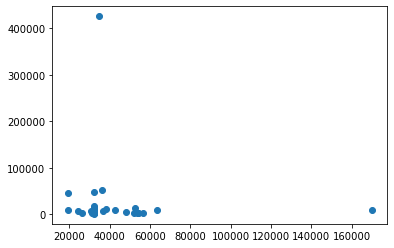

In [21]:
dfq9 = q9.toPandas()
plt.scatter(dfq9['meanMedian'], dfq9['totalExpenditure'])

In [22]:
q10 = sqlContext.sql("select * from (select distinct county, meanMedian from joinedCountyOK) as a inner join (select county, mean(totalExpenditure) as meanCleanExpenditure from joinedCountyOK group by county) as b on a.county = b.county order by meanCleanExpenditure")
q10.createOrReplaceTempView("Problem3_02")
q10.toPandas().to_csv('Problem3_02.csv', header=True, index=None)

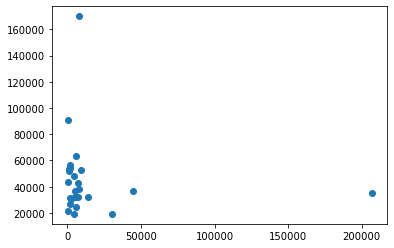

In [23]:
dfq10 = q10.toPandas()
plt.scatter(dfq10['meanCleanExpenditure'], dfq10['meanMedian'])

In [24]:
q11 = sqlContext.sql("select county, mean(expenditureIncreaseRate) as meanExpenditureIncreaseRate, mean(meanMedian) as meanMedian from (select county, (postExpenditure-preExpenditure)/preExpenditure as expenditureIncreaseRate, preYear, postYear, meanMedian from (select a.county, a.year as preYear, b.year as postYear, a.totalExpenditure as preExpenditure, b.totalExpenditure as postExpenditure, a.meanMedian from (select * from joinedCountyOK where year < 2016) as a inner join (select * from joinedCountyOK where year > 1992) as b where a.year = b.year-1 and a.county = b.county)) group by county order by county")
q11.createOrReplaceTempView("Problem3_03")
q11.toPandas().to_csv('Problem3_03.csv', header=True, index=None)

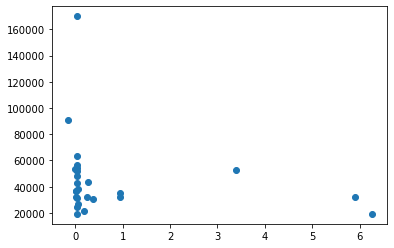

In [25]:
dfq11 = q11.toPandas()
plt.scatter(dfq11['meanExpenditureIncreaseRate'], dfq11['meanMedian'])

In [26]:
dfq11

,county,meanExpenditureIncreaseRate,meanMedian
0,Adair County,0.036881,63308.972772
1,Bryan County,0.195478,21538.000000
2,Caddo County,0.249552,31854.000000
3,Carter County,-0.006445,53521.000000
4,Cherokee County,0.373354,30578.000000
5,Choctaw County,0.039288,19519.000000
6,Cleveland County,3.399268,52368.000000
7,Coal County,6.264463,19225.000000
8,Comanche County,0.044757,170004.000000
9,Creek County,0.951933,32440.000000
